# Map fires in KI using Entropy/Alpha
- Fire Mapping in SAR Reference https://www.mdpi.com/2072-4292/9/8/764/htm
- Locate Datasets over KI using [Copernicus Hub Australia](https://copernicus.nci.org.au/sara.client/#/explore?page=1&collection=S1&instrument=C-SAR&productType=SLC&startDate=2019-12-01&completionDate=2020-01-31&geometry=POLYGON((15260443.201246085%20-4267941.237780532,15305388.173877768%20-4264578.008535984,15309974.395574879%20-4296375.812302617,15262277.68992493%20-4295152.819850055,15260443.201246085%20-4267941.237780532))].
- Download them form [NCI Thredds](http://dapds00.nci.org.au/thredds/catalog/fj7/Copernicus/Sentinel-1/C-SAR/SLC/catalog.xml).
- Load them via GDAL [Complex Tiff](https://gdal.org/drivers/raster/gtiff.html) with Cfloat64 datatype, allocate enough RAM for this.
- Analyse them in Slant Range with [PyRAT](https://github.com/birgander2/PyRAT)
- Convert to Ground range/Orthorectified versions using SNAP/Gamma

In [1]:
base_url = 'http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC'

In [2]:
loc_folder = '35S135E-40S140E'
scene_ids = [
    'S1A_IW_SLC__1SDV_20191206T200535_20191206T200604_030232_0374CC_4087',
    'S1A_IW_SLC__1SDV_20191218T200535_20191218T200604_030407_037ADB_ECEF',
    'S1A_IW_SLC__1SDV_20191230T200534_20191230T200603_030582_0380DF_1797',
    'S1A_IW_SLC__1SDV_20200111T200534_20200111T200603_030757_0386EE_B6A2'
]

In [3]:
import requests
import zipfile
import os
import re
import urllib.request
import glob
import xarray
import zipfile
from pylab import plot, show, imshow, figure
import matplotlib.pyplot as plt

In [4]:
def parse_ym(granule_name):
    ym = granule_name.replace('S1A_IW_SLC__1SDV_','')[:6]
    return ym[:4],ym[-2:]

In [5]:
def compose_url(scene_id):
    year,month = parse_ym(scene_id)
    full_url = f'{base_url}/{year}/{year}-{month}/{loc_folder}/{scene_id}.zip'
    return full_url

In [6]:
for scene in scene_ids:
    url = compose_url(scene)
    print(url)
    filename = f'{scene}.zip'
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url,filename)
        except HTTPError as hte:
            print(f"Failed to Download:{url}")

http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191206T200535_20191206T200604_030232_0374CC_4087.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191218T200535_20191218T200604_030407_037ADB_ECEF.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S135E-40S140E/S1A_IW_SLC__1SDV_20191230T200534_20191230T200603_030582_0380DF_1797.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S135E-40S140E/S1A_IW_SLC__1SDV_20200111T200534_20200111T200603_030757_0386EE_B6A2.zip


In [7]:
for scene in scene_ids:
    filename = f'{scene}.zip'
    out_dir = f'{scene}.SAFE'
    print(out_dir)
    if not os.path.isdir(f'{scene}.SAFE'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            try:
                zip_ref.extractall('.')
            except:
                print(f"Corrupted :{filename}")
                os.unlink(filename)

S1A_IW_SLC__1SDV_20191206T200535_20191206T200604_030232_0374CC_4087.SAFE
S1A_IW_SLC__1SDV_20191218T200535_20191218T200604_030407_037ADB_ECEF.SAFE
S1A_IW_SLC__1SDV_20191230T200534_20191230T200603_030582_0380DF_1797.SAFE
S1A_IW_SLC__1SDV_20200111T200534_20200111T200603_030757_0386EE_B6A2.SAFE


In [8]:
import os
import numpy as np

import osgeo.gdal as gdal

datasets = glob.glob('S1A*.SAFE/measurement')
data_collection = {}
for data in datasets:
    tiff_files = glob.glob(os.path.join(data,'*.tiff'))
    for tiff in tiff_files:
        if 's1a-iw2' in tiff:
            ds = gdal.Open(tiff)
            xsize = ds.RasterXSize
            ysize = ds.RasterYSize
            data = ds.ReadAsArray(int(xsize/2),int(ysize/2),1000,1000)
            data_collection[tiff] = data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


s1a-iw2-slc-vv-20200111t200534-20200111t200602-030757-0386ee-005.tiff
s1a-iw2-slc-vh-20200111t200534-20200111t200602-030757-0386ee-002.tiff
s1a-iw2-slc-vv-20191218t200535-20191218t200603-030407-037adb-005.tiff
s1a-iw2-slc-vh-20191218t200535-20191218t200603-030407-037adb-002.tiff
s1a-iw2-slc-vv-20191230t200534-20191230t200602-030582-0380df-005.tiff
s1a-iw2-slc-vh-20191230t200534-20191230t200602-030582-0380df-002.tiff
s1a-iw2-slc-vh-20191206t200535-20191206t200603-030232-0374cc-002.tiff
s1a-iw2-slc-vv-20191206t200535-20191206t200603-030232-0374cc-005.tiff


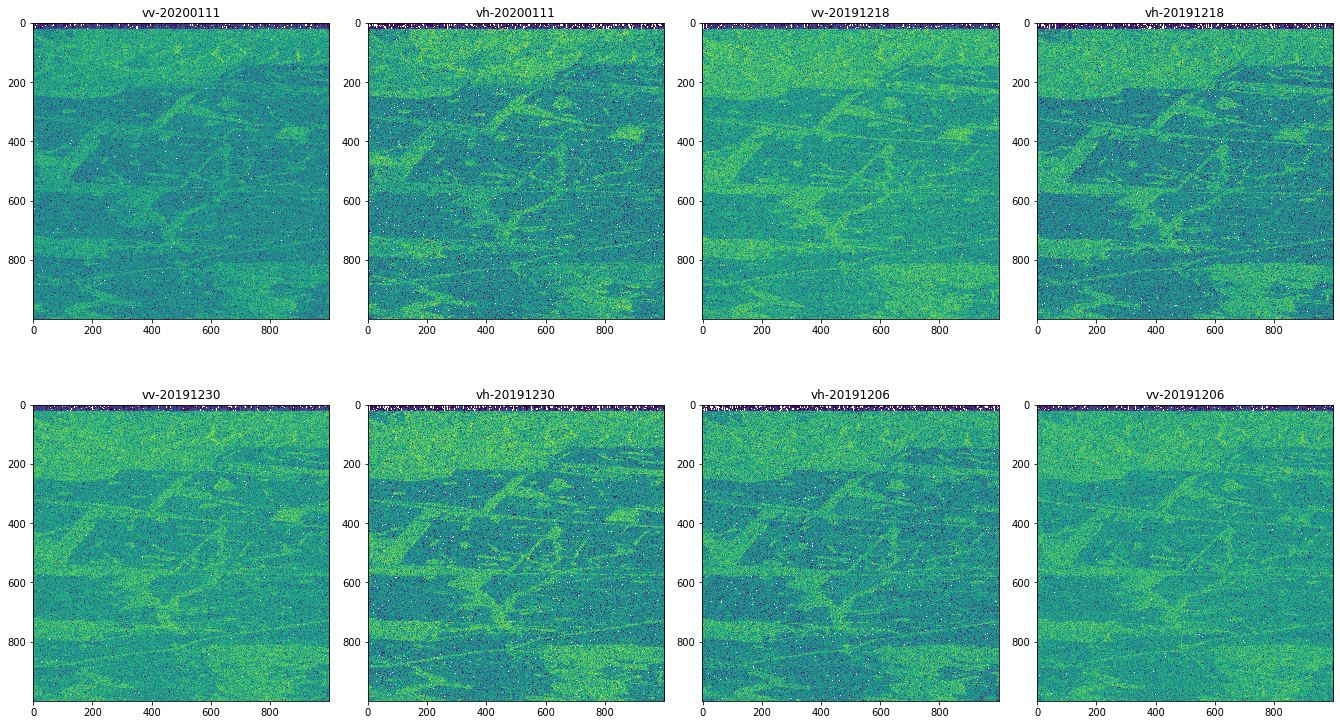

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(18.5, 10.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    decibel = np.log(np.absolute(data_collection[keys[i]])**2)*10
    ax.imshow(decibel)
    basename = os.path.basename(key)
    print(basename)
    ax.set_title(basename[12:23])
    i += 1

## Install PyRAT before next steps
- Pip install PyQT5
- Pip install Cython for acceleration
- Pip install PyRAT or clone from github to use from source

In [10]:
!pip install --user PyQT5 Cython git+https://github.com/birgander2/PyRAT

  Cloning https://github.com/birgander2/PyRAT to /tmp/pip-req-build-cbwrd0yl
  Running command git clone -q https://github.com/birgander2/PyRAT /tmp/pip-req-build-cbwrd0yl
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-cbwrd0yl/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-cbwrd0yl/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-req-build-cbwrd0yl/pip-egg-info
         cwd: /tmp/pip-req-build-cbwrd0yl/
    Complete output (27 lines):
      INFO: LeeSigma cython module not found. (run build process?)
      INFO: LeeSigma2 cython module not found. (run build process?)
      INFO: N-Dimensional Beltrami cython modules not found. (run build process?)
      INFO: Bilateral module not found. (run build process?)
      INFO: SRA